In [1]:
import numpy as np
from cosmoTransitions import generic_potential
import matplotlib.pyplot as plt
import scienceplots

In [2]:
MH = 125
MU = MH / np.sqrt(2)
LAMBDAC = 0.13
G = 0.65
GP = 0.35
YT = 1
NW = 6
NZ = 3
NH = 1
NT = 12
CW = 5/6
CZ = 5/6
CH = 3/2
CT = 3/2

In [3]:
from scipy import integrate, interpolate

INF = 20
EPSREL = 1e-8
EPSABS = 1e-8

def _Jb_exact2(theta):
    # Note that this is a function of theta so that you can get negative values
    f = lambda y: y*y*np.log(1-np.exp(-np.sqrt(y*y+theta))).real
    if theta >= 0:
        return integrate.quad(f, 0, INF, epsabs=EPSABS, epsrel=EPSREL)[0]
    else:
        f1 = lambda y: y*y*np.log(2*abs(np.sin(np.sqrt(-theta-y*y)/2)))

        if np.abs(theta)**.5 < INF:
            return (
                integrate.quad(f, np.abs(theta)**.5, INF, epsabs=EPSABS, epsrel=EPSREL)[0] +
                integrate.quad(f1, 0, np.abs(theta)**.5, epsabs=EPSABS, epsrel=EPSREL)[0]
            )
        else:
            return integrate.quad(f1, 0, np.abs(theta)**.5, epsabs=EPSABS, epsrel=EPSREL)[0]
    # def f(y):
    #     sum = theta + y*y
    #     if sum > 0:
    #         return y*y*np.log(1-np.exp(-np.sqrt(sum))).real
    #     else:
    #         return y*y*np.log(2*abs(np.sin(np.sqrt(-sum)/2)))
    # return integrate.quad(f, 0, INF)[0]
    
def _Jf_exact2(theta):
    # Note that this is a function of theta so that you can get negative values
    f = lambda y: -y*y*np.log(1+np.exp(-np.sqrt(y*y+theta))).real
    return integrate.quad(f, 0, INF, epsabs=EPSABS, epsrel=EPSREL)[0]
    
def arrayFunc(f, x, typ=float):
    # This function allows a 1D array to be passed to something that
    # normally can't handle it
    i = 0
    try:
        n = len(x)
    except:
        return f(x)  # x isn't an array
    s = np.empty(n, typ)
    while(i < n):
        try:
            s[i] = f(x[i])
        except:
            s[i] = np.NaN
        i += 1
    return s

def Jf_exact2(theta):
    """Jf calculated directly form the integral; input is theta = x^2."""
    return arrayFunc(_Jf_exact2, theta)

def Jb_exact2(theta):
    """Jb calculated directly form the integral; input is theta = x^2."""
    return arrayFunc(_Jb_exact2, theta)

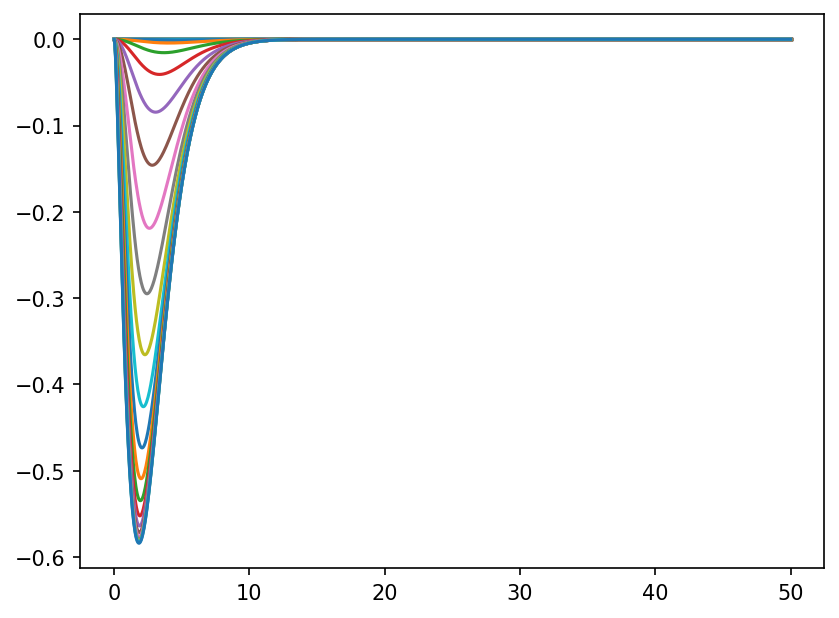

In [4]:
T_test = np.logspace(-3, 3, 61, 10)
M_test = 90

theta_test = (M_test/T_test)**2

def f_test(y, theta):
    sum = theta + y*y
    if sum >= 0:
        return y*y*np.log(1-np.exp(-np.sqrt(sum))).real
    else:
        return y*y*np.log(2*abs(np.sin(np.sqrt(-sum)/2)))

x_test = np.linspace(0, 50, 1000)
y_test_vec = [arrayFunc(lambda y: f_test(y,theta), x_test) for theta in theta_test]

plt.figure(dpi=150)
for i, y_test in enumerate(y_test_vec):
    plt.plot(x_test, y_test)
# plt.legend()
plt.show()

In [5]:
class HiggsPotential():
    def __init__(self, *args, **dargs):
        self.Ndim = 1
        self.x_eps = .001
        self.T_eps = .001
        self.deriv_order = 4
        self.renormScaleSq = 246**2
        self.Tmax = 1e3

        self.num_boson_dof = self.num_fermion_dof = None

        self.phases = self.transitions = None  # These get set by getPhases
        self.TcTrans = None  # Set by calcTcTrans()
        self.TnTrans = None  # Set by calcFullTrans()

        self.l = MU**2 / self.renormScaleSq

        # self.init(*args, **dargs)

        # if self.Ndim <= 0:
        #     raise ValueError("The number of dimensions in the potential must "
        #                      "be at least 1.")

    # EFFECTIVE POTENTIAL CALCULATIONS -----------------------
    def V0(self, phi):
        phi = np.asanyarray(phi)
        return -0.5 * MU**2 * phi**2 + 0.25 * self.l * phi**4
    
    def boson_massSq(self, phi, T):
        phi = np.asanyarray(phi)

        m_W = 0.25 * G**2 * phi**2
        m_Z = 0.25 * (G**2 + GP**2) * phi**2
        m_H = 3 * self.l * phi**2 - MH**2

        M = np.column_stack([m_W, m_Z, m_H])
        dof = np.array([NW, NZ, NH])
        c = np.array([CW, CZ, CH])

        return M, dof, c
    
    def fermion_massSq(self, phi):
        phi = np.asanyarray(phi)

        m_t = 0.5 * YT**2 * phi**2
        M = m_t.reshape(-1,1)
        dof = np.array([NT])
        
        return M, dof

    def V1(self, bosons, fermions):
        # This does not need to be overridden.
        m2, n, c = bosons
        y = np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-100)
                              - c), axis=-1)
        m2, n = fermions
        c = 1.5
        y -= np.sum(n*m2*m2 * (np.log(np.abs(m2/self.renormScaleSq) + 1e-100)
                               - c), axis=-1)
        return y/(64*np.pi*np.pi)
    
    def V1T(self, bosons, fermions, T, include_radiation=True):
        # This does not need to be overridden.
        T2 = (T*T) + 1e-100
        T4 = T*T*T*T
        m2, nb, c = bosons
        y = np.sum([nb[i]*Jb_exact2(m2[:,i]/T2) for i in range(len(nb))], axis=0)
        m2, nf = fermions
        y += np.sum([nf[i]*Jf_exact2(m2[:,i]/T2) for i in range(len(nf))], axis=0)
        if include_radiation:
            if self.num_boson_dof is not None:
                nb = self.num_boson_dof - np.sum(nb)
                y -= nb * np.pi**4 / 45.
            if self.num_fermion_dof is not None:
                nf = self.num_fermion_dof - np.sum(nf)
                y -= nf * 7*np.pi**4 / 360.
        return y*T4/(2*np.pi*np.pi)
    
    def V1T_from_X(self, X, T, include_radiation=True):
        """
        Calculates the mass matrix and resulting one-loop finite-T potential.

        Useful when calculate temperature derivatives, when the zero-temperature
        contributions don't matter.
        """
        T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        bosons = self.boson_massSq(X,T)
        fermions = self.fermion_massSq(X)
        y = self.V1T(bosons, fermions, T, include_radiation)
        return y
    
    def Vtot(self, X, T, include_radiation=True):
        # T = np.asanyarray(T, dtype=float)
        X = np.asanyarray(X, dtype=float)
        bosons = self.boson_massSq(X,T)
        fermions = self.fermion_massSq(X)
        y = self.V0(X)
        y += self.V1(bosons, fermions)
        y += self.V1T(bosons, fermions, T, include_radiation)
        return y

In [6]:
V = HiggsPotential()

In [7]:
phi = np.linspace(0, 500, 100)
phi = np.asarray(phi)

In [8]:
v0 = V.V0(phi)
T_vec = [50, 150, 200]
vtot_vec = [V.Vtot(phi, T, include_radiation=False) for T in T_vec]

In [9]:
vtot_modified = [v - v[0] for v in vtot_vec]

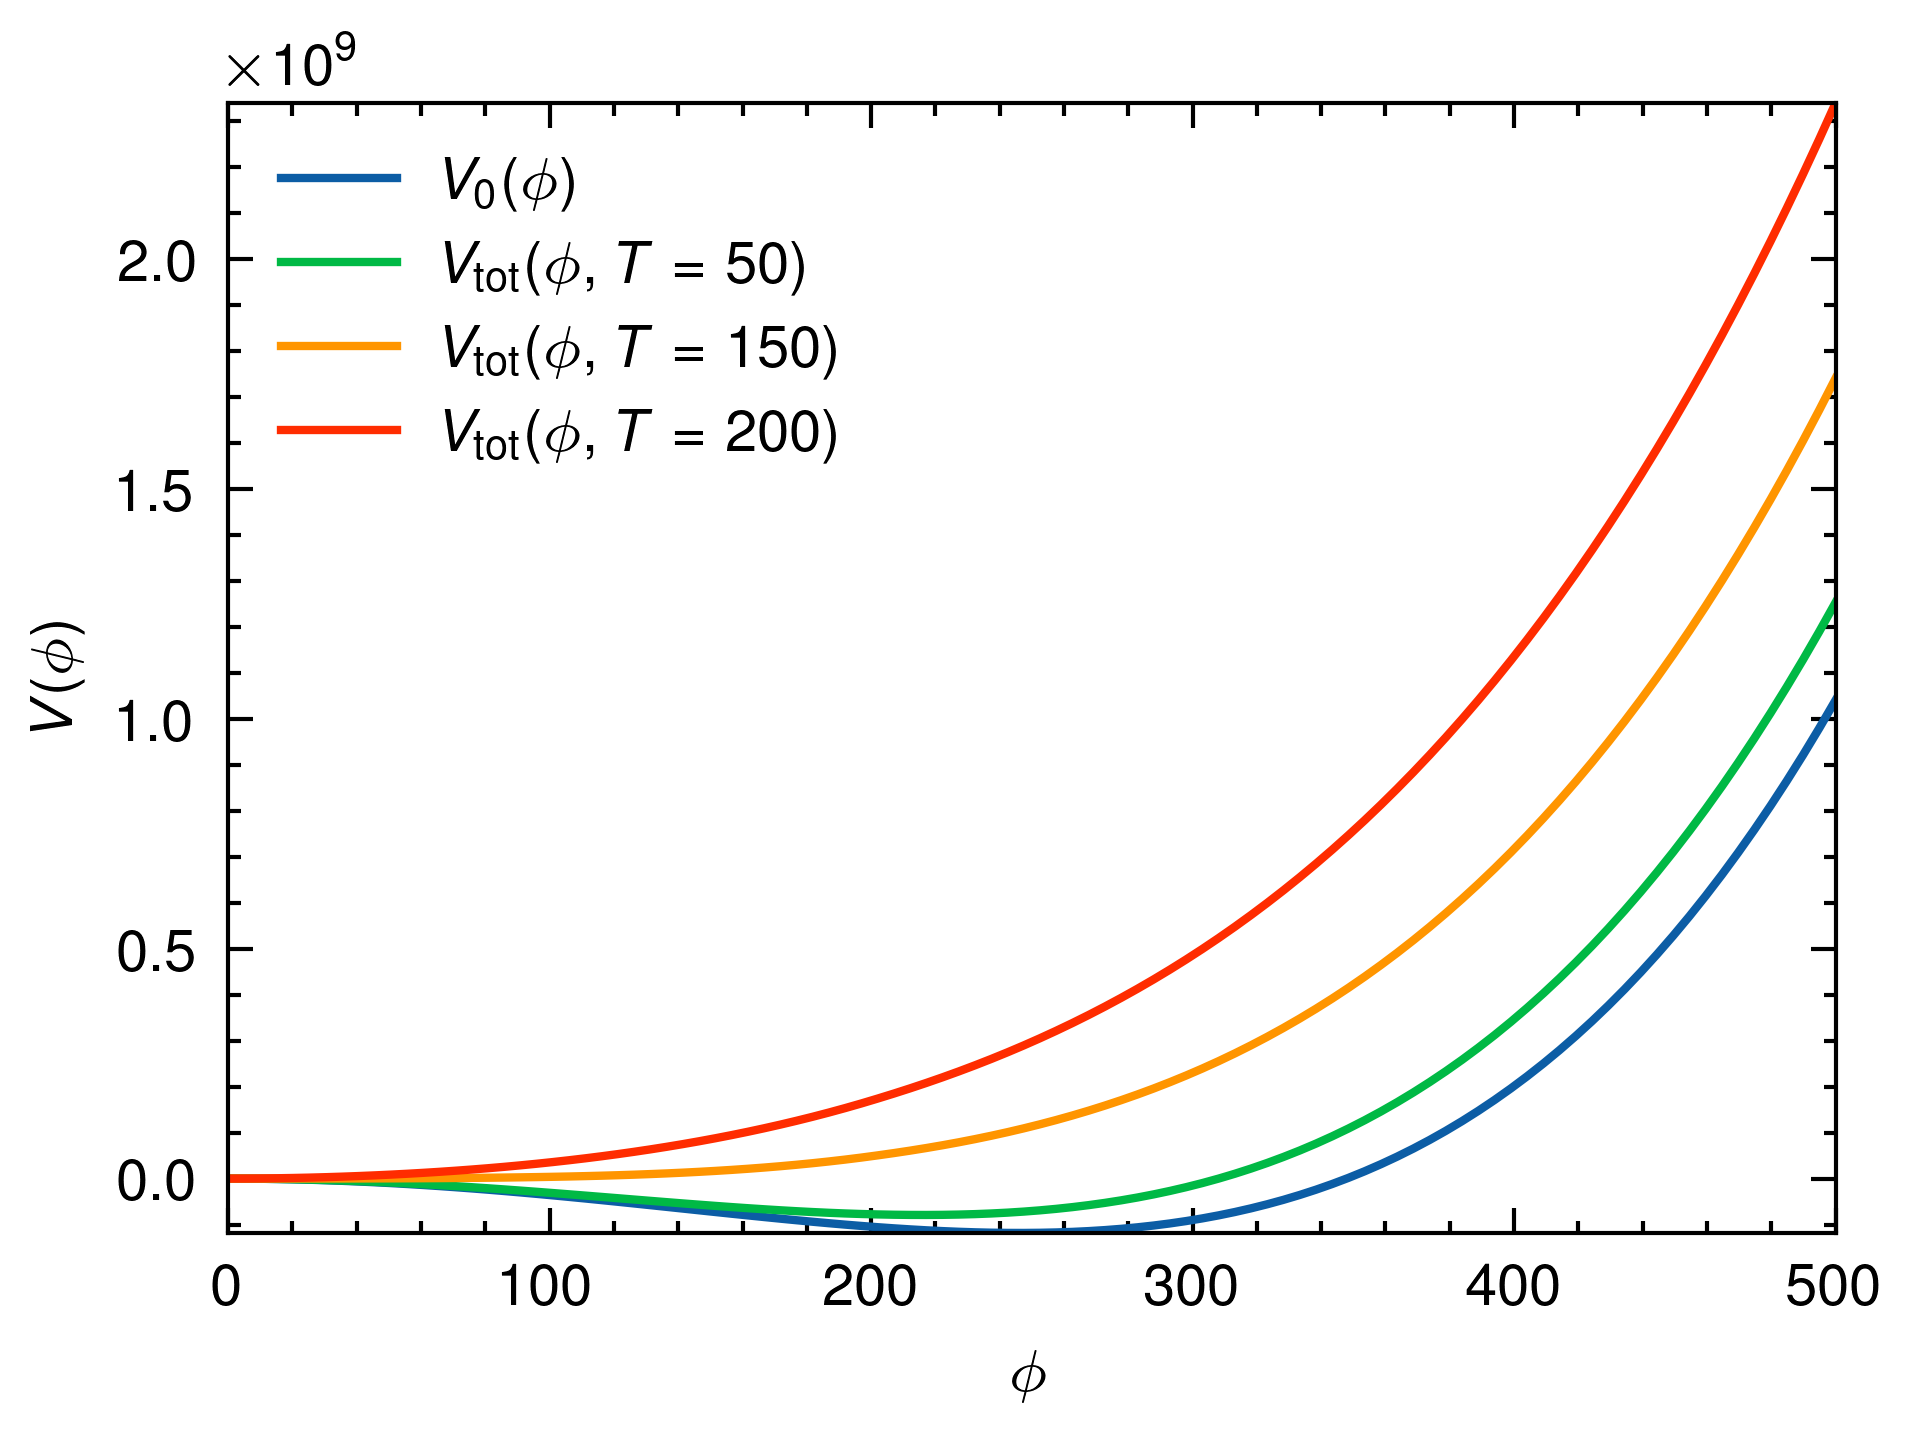

In [10]:
with plt.style.context(["science", "nature"]):
    plt.figure(dpi=600)
    plt.plot(phi, v0, label=r"$V_0(\phi)$")
    for i, T in enumerate(T_vec):
        plt.plot(phi, vtot_modified[i], label=r"$V_{\text{tot}}(\phi, T = %d)$" % T)
    plt.xlabel(r"$\phi$")
    plt.ylabel(r"$V(\phi)$")
    plt.autoscale(tight=True)
    plt.tight_layout()
    plt.legend()
    plt.show()